<a href="https://colab.research.google.com/github/mariiacamila31/Linear_Regression_ICVT/blob/main/Linear_Regression_ICVT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Net Asset Value Prediction using Multiple Linear Regression: Convertible "Junk" Bond - iShares Convertible Bond ETF  (BATS: ICVT)**

The iShares Convertible Bond ETF (ICVT) by BlackRock has shown notable performance patterns since its inception.
- **Growth and Returns**:
  - Historically, ICVT has offered competitive returns, driven by the combination of debt and equity characteristics.
  - Convertible bonds in the ETF have often outperformed traditional bonds due to the potential for equity-like returns.
- **Market Environment**:
  - Performance has been influenced by market conditions, such as interest rates, economic growth, and equity market performance.
  - In bullish equity markets, ICVT has benefited from the equity upside of convertible bonds.
  - In bearish or volatile markets, the fixed-income component has provided some downside protection.
- **Risk and Volatility**:
  - ICVT has exhibited higher volatility compared to traditional bond ETFs due to its exposure to junk bonds and equity market swings.
  - The ETF’s price dynamics have reflected the higher risk of default associated with its holdings.
- **Yield**:
  - Historically, ICVT has offered attractive yields, compensating investors for the higher risk associated with its underlying securities.
- **Comparative Performance**:
  - Compared to pure equity or fixed-income ETFs, ICVT has offered a balanced risk-reward profile, appealing to investors seeking diversified exposure with potential for capital appreciation and income.
- **Key Events**:
  - Significant market events, such as the financial crises and economic downturns, have impacted ICVT’s performance, highlighting its sensitivity to macroeconomic factors.



In [85]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import seaborn as sns
%matplotlib inline

##1. Load and clean the data

In [57]:
# Load the data with the Net Asset Value of the Portfolio
data = pd.read_csv("/content/NAV_ICVT.csv")

# View the data
data.head()

,As Of,NAV per Share
0,2024-05-16,78.91
1,2024-05-15,79.10
2,2024-05-14,78.45
3,2024-05-13,78.06
4,2024-05-10,77.86


In [58]:
# View the data types
data.dtypes

As Of             object
NAV per Share    float64
dtype: object

In [59]:
# Convert to a data frame
df = pd.DataFrame(data)

# Change the column names
df = df.rename({"As Of" : "Date", "NAV per Share" : "NAV"}, axis = 1)

# View the changes
df

,Date,NAV
0,2024-05-16,78.91
1,2024-05-15,79.10
2,2024-05-14,78.45
3,2024-05-13,78.06
4,2024-05-10,77.86
...,...,...
2253,2015-06-08,49.12
2254,2015-06-05,49.43
2255,2015-06-04,49.24
2256,2015-06-03,49.51


In [60]:
# View summary information about the DataFrame
print("Summary information:")
print(df.info())

Summary information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2258 non-null   object 
 1   NAV     2258 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.4+ KB
None


In [61]:
# View summary statistics of numerical columns
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
               NAV
count  2258.000000
mean     66.134008
std      16.844986
min      40.090000
25%      53.172500
50%      59.880000
75%      76.560000
max     109.890000


##2. Create visualizations

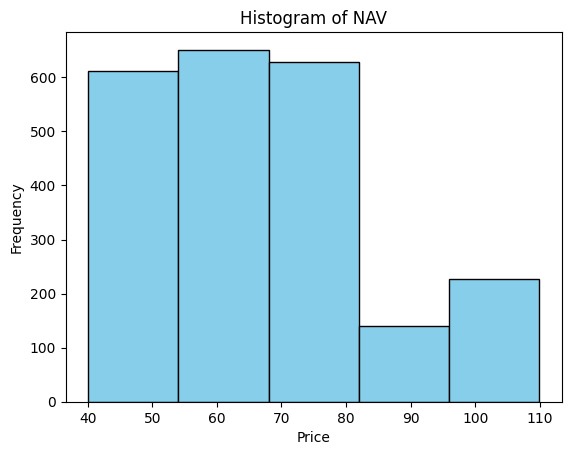

In [62]:
# Plot a histogram to visualize the data distribution
plt.hist(df["NAV"], bins=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of NAV')

# Show the plot
plt.grid(False)
plt.show()

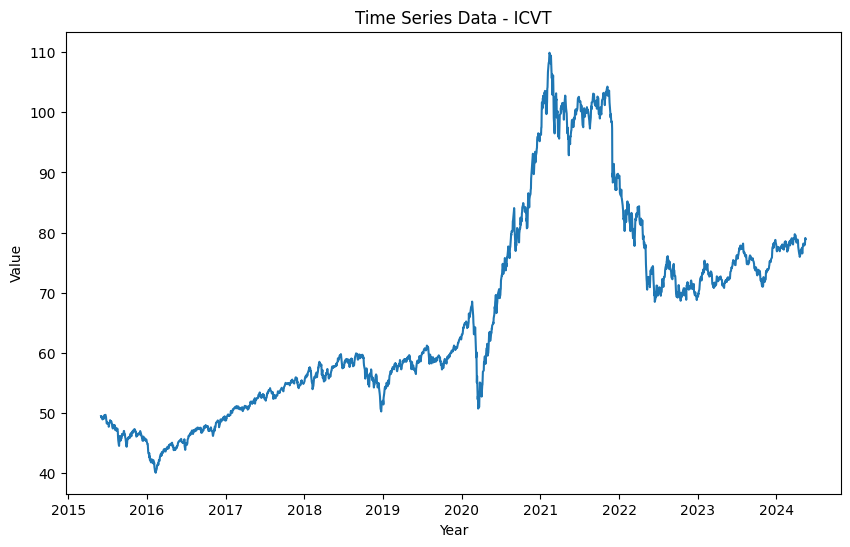

In [63]:
# Change data type from character to "Date"
df["Date"] = pd.to_datetime(df["Date"])

# Plot the time series data to visualize the Net Asset Value movement
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df["Date"], df["NAV"], linestyle='-')
plt.title("Time Series Data - ICVT")
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(False)
plt.show()

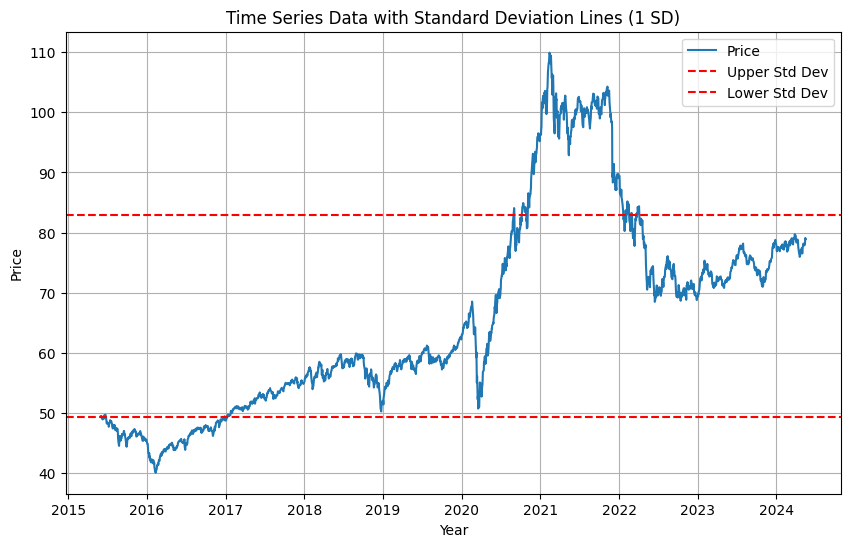

In [64]:
# Calculate standard deviation
std_dev = df["NAV"].std()

# Plot the time series data
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df["Date"], df["NAV"], linestyle='-', label="Price")
plt.axhline(y=df["NAV"].mean() + std_dev, color='r', linestyle='--', label='Upper Std Dev')
plt.axhline(y=df["NAV"].mean() - std_dev, color='r', linestyle='--', label='Lower Std Dev')
plt.title('Time Series Data with Standard Deviation Lines (1 SD)')
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

###The line chart above confirms that the majority of ICVT's prices ranged from approximately `$50` to `$80` between 2017 and 2024.

In [65]:
# Convert the date to date time
df["Date"] = pd.to_datetime(df["Date"])
df.dtypes

# Convert the date numerical
df["Date"] = pd.to_datetime(df["Date"])
df["date_ordinal"] = df['Date'].map(pd.Timestamp.toordinal)

# Now convert to float
df["date_ordinal"] = df["date_ordinal"].astype(float)

# Check the data types
df.dtypes

Date            datetime64[ns]
NAV                    float64
date_ordinal           float64
dtype: object

##3. Calculate the metrics (features)

In [66]:
# Make the date column the index for the model
df.set_index(df["Date"], inplace = True)

# Drop the extra date column, run this line only once.
# df.drop(["Date"], axis = 1, inplace = True)

'''
From the function below:

When creating features using lags, the function create_features generates lagged versions of the NAV variable,
where each lag represents the NAV value from a specific number of time periods in the past.
These lagged features are then used as input variables in the predictive model.

These lagged features capture the temporal dependencies and patterns in the NAV values,
enabling the model to learn from past observations to make predictions about future NAV values
'''

#Create a function to calculate the lags
def create_features(df, lags = 5):
  df = df.copy()
  for i in range(1, lags + 1):
    df[f"lag_{i}"] = df["NAV"].shift(i)

  # Now the metrics
  df["Rolling_mean_5"] = df["NAV"].rolling(window = 5).mean()
  df["Rolling_mean_10"] = df["NAV"].rolling(window = 10).mean()

  df.dropna(inplace = True)
  return df

df_features = create_features(df)

# View the dataset
df_features

,NAV,date_ordinal,lag_1,lag_2,lag_3,lag_4,lag_5,Rolling_mean_5,Rolling_mean_10
Date,,,,,,,,,
2024-05-03,77.58,739009.0,78.18,78.06,77.90,78.10,77.86,77.964,78.220
2024-05-02,77.02,739008.0,77.58,78.18,78.06,77.90,78.10,77.748,78.031
2024-05-01,76.53,739007.0,77.02,77.58,78.18,78.06,77.90,77.474,77.774
2024-04-30,76.76,739006.0,76.53,77.02,77.58,78.18,78.06,77.214,77.605
2024-04-29,77.41,739005.0,76.76,76.53,77.02,77.58,78.18,77.060,77.540
...,...,...,...,...,...,...,...,...,...
2015-06-08,49.12,735757.0,48.95,49.23,49.37,49.19,49.06,49.172,49.263
2015-06-05,49.43,735754.0,49.12,48.95,49.23,49.37,49.19,49.220,49.250
2015-06-04,49.24,735753.0,49.43,49.12,48.95,49.23,49.37,49.194,49.207


In [43]:
# Define the dependent and independent variables
X = df_features.drop(["NAV"], axis = 1)
y = df_features["NAV"]

# Check data types and remove datetime columns if any
print("Data types of X before conversion:\n", X.dtypes)
X = X.select_dtypes(exclude=['datetime64[ns]'])
print("Data types of X after conversion:\n", X.dtypes)

Data types of X before conversion:
 date_ordinal       float64
lag_1              float64
lag_2              float64
lag_3              float64
lag_4              float64
lag_5              float64
Rolling_mean_5     float64
Rolling_mean_10    float64
dtype: object
Data types of X after conversion:
 date_ordinal       float64
lag_1              float64
lag_2              float64
lag_3              float64
lag_4              float64
lag_5              float64
Rolling_mean_5     float64
Rolling_mean_10    float64
dtype: object


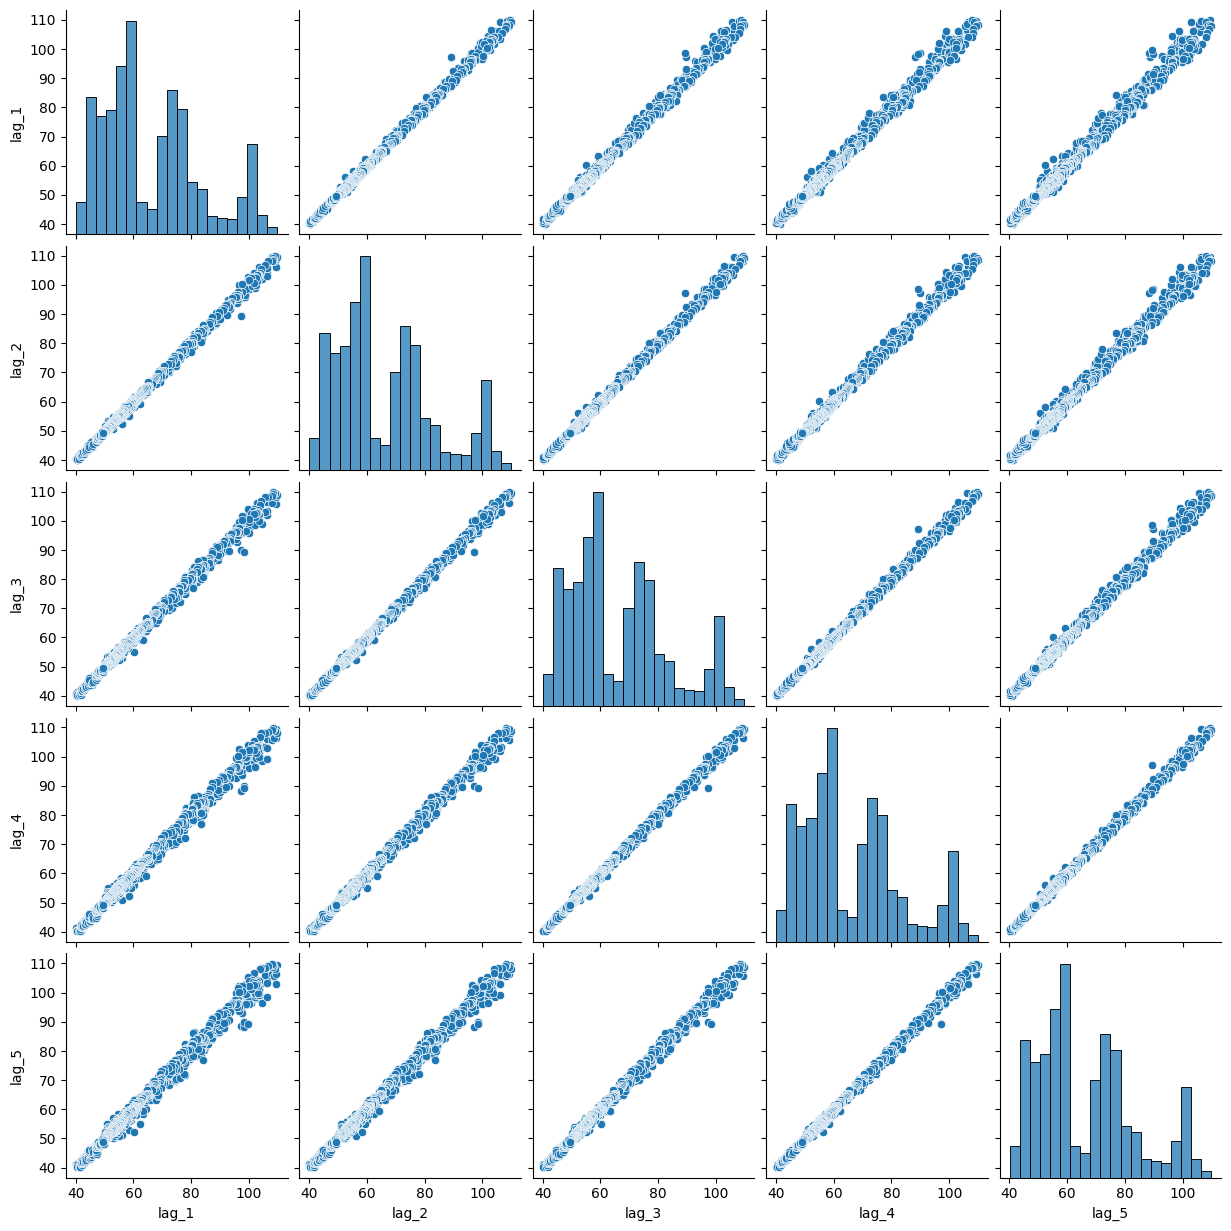

In [91]:
# Create a pair plot for each lag used to train the model
sns.pairplot(X)
plt.show()

- **Diagonal Plots**:
  - The diagonal plots typically display the distribution of each variable, ranging from lag 1 through lag 5, visualized as histograms in this instance.
- **Pair Plots**:
  - Pair plots serve to unveil patterns, correlations, and potential outliers within the dataset. Notably, all variables exhibit positive correlations. Moreover, certain variables manifest a "thicker" distribution towards the far right of the graph, suggesting higher variance from the actual values.

##4. Modeling: Multiple Linear Regression

Cross-Validation R^2 Scores: [0.99886018 0.9989765  0.99861235 0.99867265 0.99851139]
Mean Cross-Validation R^2 Score: 0.9987266156272241
Standard Deviation of Cross-Validation R^2 Scores: 0.00016886351845565409
Mean Squared Error: 0.4665100283343398
R^2 Score: 0.9981396319379283


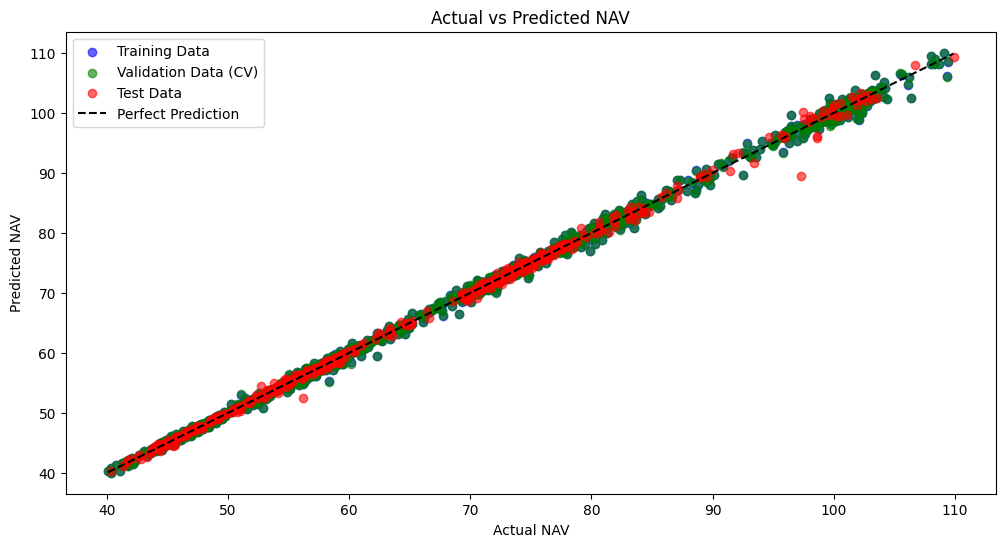

In [86]:
# Split the dataset
X = df_features.drop(["NAV", "date_ordinal", "Rolling_mean_5", "Rolling_mean_10"], axis = 1)
y = df_features["NAV"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline to standardize the data and apply Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Perform 5-fold cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

# Print cross-validation scores
print(f'Cross-Validation R^2 Scores: {cv_scores}')
print(f'Mean Cross-Validation R^2 Score: {cv_scores.mean()}')
print(f'Standard Deviation of Cross-Validation R^2 Scores: {cv_scores.std()}')

# Perform cross-validation on the training data to get validation predictions
y_val_pred = cross_val_predict(pipeline, X_train, y_train, cv=5)

# Train the model on the entire training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate R^2 Score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Predict on the training data
y_train_pred = pipeline.predict(X_train)

# Predict on the test data
y_test_pred = pipeline.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Training Data', alpha=0.6)
plt.scatter(y_train, y_val_pred, color='green', label='Validation Data (CV)', alpha=0.6)
plt.scatter(y_test, y_test_pred, color='red', label='Test Data', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual NAV')
plt.ylabel('Predicted NAV')
plt.title('Actual vs Predicted NAV')
plt.legend()
plt.show()

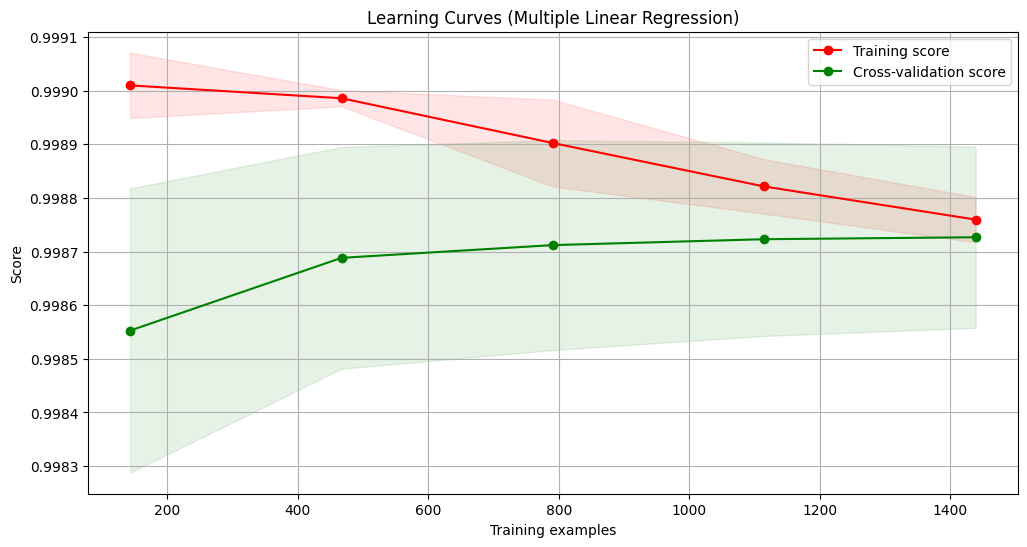

In [84]:
# Define a function to plot learning curves
def plot_learning_curve(estimator, X, y, title="Learning Curves", cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
plot_learning_curve(pipeline, X_train, y_train, title="Learning Curves (Multiple Linear Regression)")
plt.show()


**Graph Interpretation**:

- The `plot_learning_curve` function is designed to visualize the learning curves of a model.
- This function utilizes `learning_curve` from `sklearn` to calculate training and validation scores for varying training set sizes.
- The `plot_learning_curve` function is then called to generate the learning curves for the linear regression model.
- The resulting plot displays both the training score and the cross-validation score as a function of the number of training examples, illustrating how the model's performance improves with more data.

## 5. Evaluate the model's performance

In [ ]:
# Create a pipeline with standardization and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test).round(2)

# Create a DataFrame with actual and predicted prices
results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred
})

# Show the results
results.head()

,Actual Price,Predicted Price
Date,,
2015-07-27,47.43,47.83
2022-06-06,73.89,74.43
2017-03-07,50.74,50.66
2023-05-12,71.83,72.12
2017-10-05,54.95,55.03


In [ ]:
#Finally, create a data set displaying the price difference between the 2 different columns
results["Difference"] = (results["Predicted Price"]- results["Actual Price"]).round(2)
results

,Actual Price,Predicted Price,Difference
Date,,,
2015-07-27,47.43,47.83,0.40
2022-06-06,73.89,74.43,0.54
2017-03-07,50.74,50.66,-0.08
2023-05-12,71.83,72.12,0.29
2017-10-05,54.95,55.03,0.08
...,...,...,...
2023-11-20,73.92,73.62,-0.30
2024-01-18,77.03,77.24,0.21
2022-09-09,74.30,74.80,0.50


In [ ]:
results.describe()

,Actual Price,Predicted Price,Difference
count,450.000000,450.000000,450.000000
mean,65.670756,65.678778,0.008022
std,15.853098,15.847645,0.683711
min,40.300000,40.330000,-7.830000
25%,53.687500,53.742500,-0.210000
50%,60.395000,60.490000,0.050000
75%,75.307500,75.457500,0.300000
max,109.890000,109.390000,2.650000


In [ ]:
# Calculate the difference between the min and max values for the actual prices
min_value = results["Actual Price"].min()
max_value = results["Actual Price"].max()
difference = max_value - min_value

print(f"The difference between the max and min values in for the actual price is: ${difference}")

The difference between the max and min values in for the actual price is: $69.59
